In [6]:
import dash
import dash_split_pane
from dash import html
from dash.dependencies import Output, Input
from dash.exceptions import PreventUpdate
from dash import dcc
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash

In [3]:
!pip install dash_split_pane

     |████████████████████████████████| 41 kB 205 kB/s eta 0:00:011
  Created wheel for dash-split-pane: filename=dash_split_pane-1.0.0-py3-none-any.whl size=42684 sha256=32990092c567bfee8145b937ace7318a09104047efc6a6c4112c855f34b91ff5
  Stored in directory: /Users/lin/Library/Caches/pip/wheels/69/d8/c8/a9fb5a34e9b08270dcac2961a6de399626e431088b66ff0cf6
Successfully built dash-split-pane


In [158]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from dash_table import DataTable
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [64]:
### Script to open our JSON file

 

import pandas as pd

import json

 

#filename = 'ad5941_HNT_RevB4_U0_Dry_Script2634157_A1_T1_TestRigPune_1_TS_012.json'

filename = '/Users/lin/Desktop/Assistme/ad5941_HNT_RevB4_U0_Dry_Script2634157_A1_T1_TestRigPune_1_TS_012.json'

with open(filename, 'r') as json_in:

    json_data = json.load(json_in)

 

df = pd.DataFrame(json_data)

 

 

In [160]:
app = JupyterDash(__name__, external_stylesheets = [dbc.themes.DARKLY])

## convert time_stamp to datetime object
df.time_stamp = pd.to_datetime(df.time_stamp)

## set timstamp as index
df.index = df.time_stamp



## repeat removing outliers in decay
## decay values > 0.2 are treated as outliers and removed
df_outlier_rm = df_outlier_rm[(df_outlier_rm.decay <= 0.2) & (df_outlier_rm.decay > 0)]


## remove outliers of offset
df_outlier_rm = df_outlier_rm[(df_outlier_rm.offset > 0) & (df_outlier_rm.offset < 330)]

df_outlier_rm = df_outlier_rm[(df_outlier_rm.scale > -10) & (df_outlier_rm.scale < 50)]

df_outlier_rm = df_outlier_rm.drop('time_stamp', 1)  ## remove timestamp column

X = StandardScaler().fit_transform(df_outlier_rm)


## correlation matrix 
corr = df_outlier_rm.corr()

########## creating a mask to hide the upper triangle  ##############
## creat mask of same shape as corr
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

fig = go.Figure()


app.layout = html.Div([
    html.Br(),
    dcc.Tabs([
        #html.Br(),# html.Br(),
        dcc.Tab(id='data_display', label='Dataset', style={'backgroundColor':'#1Fdff3'},
               children=[html.Div(dbc.Col([
                   DataTable(data= df.to_dict('record'),
                            columns=[{'name': col, 'id': col} for col in df.columns],
                             style_header={'whiteSpace': 'normal'},
                            fixed_rows={'header': True},
                            virtualization=True,
                            style_as_list_view = True,
                            style_table={'height': '400px'},
                            sort_action='native',
                            filter_action='native',
                            export_format='csv',
                            style_cell={'minWidth': '150px'}
                            )
               ]))]),
        
        dcc.Tab(id='data_explore', label='Data visualization', style={'backgroundColor':'blue'},
                children=[dbc.Row(children=[
                      dbc.Col([#id='hist', 
                          html.Br(),
                             dcc.Graph(id='line_graph_decay',
                                      figure = px.line(data_frame=df, x=df.index, y='decay')),
                          html.Br(),
                          dcc.Graph(id='line_graph_scale',
                                   figure=px.line(data_frame=df, y=df.scale))
                      ]),
                       dbc.Col([#id='boxplot',
                           html.Br(),
                              dcc.Graph(id='line_graph_offset',
                                       figure=px.line(data_frame=df, y=df.offset))
                       ])
                
                       ]),
                dbc.Row([dbc.Label('Histogram plots'), #id='scatter',
                       dbc.Col(children=[#id='scatter_plots',
                              dcc.Graph(id='histogram_graph_decay',
                                       figure=px.histogram(data_frame=df_outlier_rm, x='decay')
                                       ),
                           html.Br(),
                           dcc.Graph(id='histogram_graph_scale',
                                    figure=px.histogram(data_frame=df_outlier_rm, x='offset'))
                       ]),
                         html.Br(),
                        dbc.Col(children=[#id='timeseries_col',
                               dcc.Graph(id='histogram_graph_offset',
                                        figure=px.histogram(data_frame=df_outlier_rm, x='scale'))
                        ])
                        ]),
                dbc.Row([dbc.Label('Boxplot of Data without Outliers'),
                        dbc.Col([
                            dcc.Graph(id='boxplot_decay',
                                     figure= px.box(data_frame=df_outlier_rm, x='decay',
                                                   title='Decay with outliers removed')),
                            html.Br(),
                            dcc.Graph(id='boxplot_scale',
                                     figure=px.box(data_frame=df_outlier_rm, x = 'scale',
                                                  title='Scale with outliers removed'))
                        ]),
                        dbc.Col([
                            dcc.Graph(id='boxplot_offset',
                                     figure=px.box(data_frame=df_outlier_rm, x = 'offset',
                                                  title='Offset with outliers removed')),
                            html.Br(),
                            dcc.Graph(id='correlation_matrix',
                                     figure=px.imshow(corr, title='Correlation map'))
                        ])])
                          
        ]),
        
       # html.Br(),
        dcc.Tab(label='K-means Clustering Analysis', style={'backgroundColor': 'green'}, children=[
            dbc.Row([
                dbc.Col([
                   dbc.Label(children='Select number of clusters'),
                    dcc.Dropdown(id='cluster_dropdown', style={'backgroundColor': 'black'},
                                options=[{'label':n_cluster, 'value': n_cluster}
                                        for n_cluster in range(1, 10)])
                ], style={'width': '3%'}),
                dbc.Col([
                    dbc.Label('Graph of clusters'),
                    dcc.Graph(id='clusters')
                ])
            ]),
            dbc.Row([
                
                dbc.Col([
                    dbc.Label('Performance of the clustering'),
                    dcc.Graph(id='inertia_graph')
                    
                ])
            ])
        ])
])])

""" @app.callback(Output(component_id='line_graph_decay', component_property='figure'))
def line_plot_decay():
    fig_decay = px.line(data_frame=df, x=df.index, y='decay')
    return fig_decay
""" 

@app.callback(Output(component_id='clusters', component_property = 'figure'),
             Input(component_id='cluster_dropdown', component_property='value'))
def plot_clusters()

app.run_server(mode='inline', port=8017)

<ipython-input-160-c2c404389cac>:28: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/Users/lin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:1549: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



In [126]:

## repeat removing outliers in decay
## decay values > 0.2 are treated as outliers and removed
df_outlier_rm = df_outlier_rm[(df_outlier_rm.decay <= 0.2) & (df_outlier_rm.decay > 0)]


## remove outliers of offset
df_outlier_rm = df_outlier_rm[(df_outlier_rm.offset > 0) & (df_outlier_rm.offset < 330)]

df_outlier_rm = df_outlier_rm[(df_outlier_rm.scale > -10) & (df_outlier_rm.scale < 50)]

/Users/lin/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='decay'>

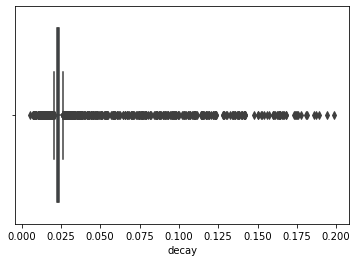

In [129]:
sns.boxplot(df_outlier_rm.decay)

/Users/lin/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='offset'>

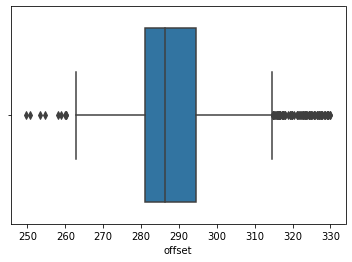

In [131]:
sns.boxplot(df_outlier_rm.offset)

/Users/lin/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='scale'>

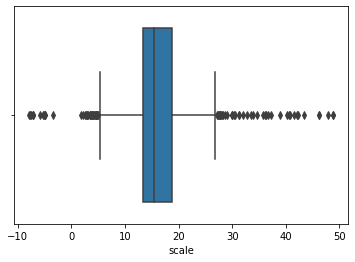

In [132]:
sns.boxplot(df_outlier_rm.scale)

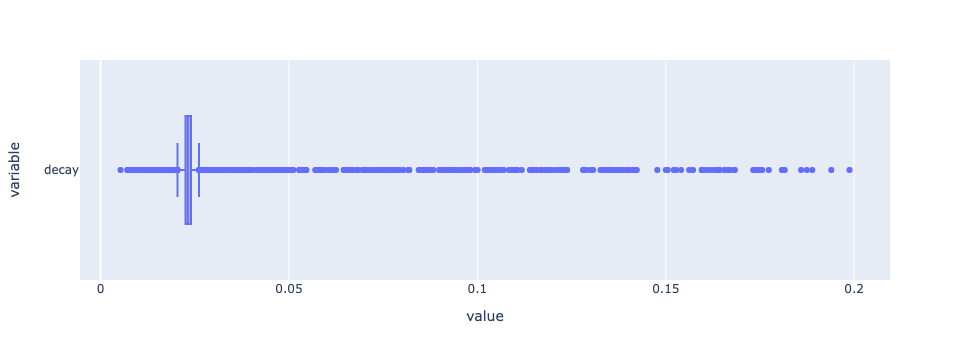

In [136]:
px.box(data_frame=df_outlier_rm, x=['decay'])

In [110]:
df_outlier_rm

,decay,offset,scale,time_stamp
time_stamp,,,,
2021-11-15 05:56:43+00:00,0.069968,295.857703,25.022848,2021-11-15 05:56:43+00:00
2021-11-15 05:56:28+00:00,0.022758,272.617566,10.259420,2021-11-15 05:56:28+00:00
2021-11-15 05:57:36+00:00,0.401177,287.804819,23.231423,2021-11-15 05:57:36+00:00
2021-11-15 05:57:04+00:00,0.299186,284.282530,18.685251,2021-11-15 05:57:04+00:00
2021-11-15 05:57:25+00:00,0.315726,290.142256,27.241219,2021-11-15 05:57:25+00:00
...,...,...,...,...
2021-11-15 11:03:56+00:00,0.024134,285.013571,16.000831,2021-11-15 11:03:56+00:00
2021-11-15 11:03:04+00:00,0.022369,284.520468,15.799095,2021-11-15 11:03:04+00:00
2021-11-15 11:03:09+00:00,0.022594,284.647386,15.791135,2021-11-15 11:03:09+00:00


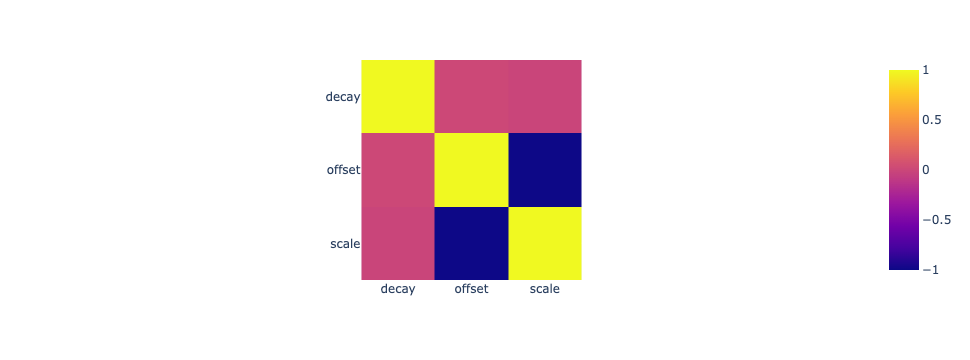

In [150]:
px.imshow(corr)

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [46]:
df = df.drop('time_stamp', 1)  ## remove timestamp column

In [47]:
X = StandardScaler().fit_transform(df)
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(X)

# ## Optimum number of clusters 

clustering_inertia = []

for num_clusters in range(1, 10):
    cluster = KMeans(n_clusters = num_clusters)
    cluster.fit(X)
    clustering_inertia.append(cluster.inertia_)



In [49]:
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(X)

## labels
kmeans.labels_

array([0, 3, 4, ..., 3, 3, 3], dtype=int32)

In [50]:
## centriods of all clusters
kmeans.cluster_centers_


array([[-0.20029129, -0.18617988,  0.70845917],
       [ 4.31297382, -0.33892954, -1.77542211],
       [-0.17511221,  2.01687695,  0.37073813],
       [-0.19024665, -0.59792475, -0.64473475],
       [-0.02492761, -0.73993326,  4.41768274]])

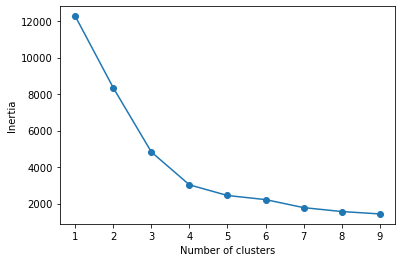

In [51]:
# ## Optimum number of clusters 

clustering_inertia = []

for num_clusters in range(1, 10):
    cluster = KMeans(n_clusters = num_clusters)
    cluster.fit(X)
    clustering_inertia.append(cluster.inertia_)


plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.plot(range(1,10), clustering_inertia, marker = 'o')



In [52]:
from sklearn.metrics import silhouette_score

In [53]:
silhouette_score(X, kmeans.labels_)




0.5522388746819011

In [54]:
## Plotting clusters

from sklearn.decomposition import PCA


In [55]:
# we will convert them to 2 dimention
pca = PCA(n_components = 2)



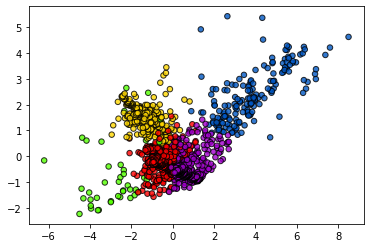

In [56]:
pca.fit(X)
pca_X = pca.transform(X)


plt.scatter(pca_X[:,0], pca_X[:,1], s = 30, c = kmeans.labels_, cmap = 'prism', alpha = 0.8, edgecolors='black',
           linewidths = 1)


## add new column labelling clusters
df['cluster'] = kmeans.labels_



In [159]:
df_outlier_rm

,decay,offset,scale,time_stamp
time_stamp,,,,
2021-11-15 05:56:43+00:00,0.069968,295.857703,25.022848,2021-11-15 05:56:43+00:00
2021-11-15 05:56:28+00:00,0.022758,272.617566,10.259420,2021-11-15 05:56:28+00:00
2021-11-15 05:58:13+00:00,0.117961,278.500856,47.940909,2021-11-15 05:58:13+00:00
2021-11-15 05:57:46+00:00,0.044008,270.039732,36.693579,2021-11-15 05:57:46+00:00
2021-11-15 06:00:09+00:00,0.118719,283.508727,8.665340,2021-11-15 06:00:09+00:00
...,...,...,...,...
2021-11-15 11:03:56+00:00,0.024134,285.013571,16.000831,2021-11-15 11:03:56+00:00
2021-11-15 11:03:04+00:00,0.022369,284.520468,15.799095,2021-11-15 11:03:04+00:00
2021-11-15 11:03:09+00:00,0.022594,284.647386,15.791135,2021-11-15 11:03:09+00:00
